In [115]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from data_fetcher import Dataset
from datetime import datetime
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# List of symbols
symbols = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'ADAUSDT', 'DOGEUSDT', 'DOTUSDT', 'XRPUSDT', 'LINKUSDT', 'LTCUSDT', 'BCHUSDT', 'UNIUSDT', 'MATICUSDT', 'SOLUSDT', 'VETUSDT', 'ETCUSDT', 'FILUSDT', 'THETAUSDT', 'XLMUSDT', 'TRXUSDT', 'EOSUSDT']



# Load the cleaned data from the pickle file
pred_copy = 'cleaned_crypto_data.pkl'





In [116]:
#Defining function for loading data
def load_and_clean_data(pred_copy):
    dt_df = pd.read_pickle(pred_copy)
    dt_df = dt_df.drop(columns=["Name"])
    return dt_df

#Defining function for creating features (future engineering)
def create_features(dt_df, symbols):
    pred_df = dt_df.copy()
    one_day = []
    seven_day = []
    thirty_day = []
    for i in symbols:
        one_day.extend(pred_df[pred_df['symbol']==i].close.shift(-1))
        seven_day.extend(pred_df[pred_df['symbol']==i].close.shift(-7))
        thirty_day.extend(pred_df[pred_df['symbol']==i].close.shift(-30))

    pred_df['t1'] = one_day
    pred_df['t7'] = seven_day
    pred_df['t30'] = thirty_day

    pred_df.dropna(inplace=True)
    return pred_df

#Calling functions
dt_df = load_and_clean_data(pred_copy)
pred_df = create_features(dt_df, symbols)

In [118]:
#Definning function for spltting into test and train
def train_test_split_function(pred_df, symbols):
    X = pred_df.drop(['close', 't1', 't7', 't30'], axis=1)
    y = pred_df[['t1', 't7', 't30']]

    # Map symbols to integers
    symbol_mapping = {symbol: i for i, symbol in enumerate(symbols)}
    X['symbol'] = X['symbol'].map(symbol_mapping)

    X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7)
    return X_train, X_test, y_train, y_test

#Definning function for scaling
def data_scaling(X_train, X_test):
    scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, scaler

# Define the symbol_mapping dictionary
symbol_mapping = {symbol: i for i, symbol in enumerate(symbols)}

X_train, X_test, y_train, y_test = train_test_split_function(pred_df, symbols)
X_train_scaled, X_test_scaled, scaler = data_scaling(X_train, X_test)

In [ ]:
#Definning function for training the model
def model_training(X_train_scaled, y_train):
    # instantiating regressor object
    regressor = DecisionTreeRegressor()
    # fitting  regressor with X and Y data
    regressor.fit(X_train_scaled, y_train)
    return regressor

In [ ]:
#Definning function to make prediction
def model_prediction(regressor, X_test_scaled):
    y_pred = regressor.predict(X_test_scaled)
    return y_pred

regressor = model_training(X_train_scaled, y_train)
y_pred = model_prediction(regressor, X_test_scaled)

In [ ]:
#Definning functions for calculating metrics
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_metrics(y_true, y_pred, dataset_type="Test"):
    y_pred_df = pd.DataFrame(y_pred, columns=['t1', 't7', 't30'])
    print(f"------- {dataset_type} Dataset Metrics -------")
    for horizon in ['t1', 't7', 't30']:
        mape = mean_absolute_percentage_error(y_true[horizon], y_pred_df[horizon])
        mae = mean_absolute_error(y_true[horizon], y_pred_df[horizon])
        rmse = np.sqrt(mean_squared_error(y_true[horizon], y_pred_df[horizon]))
        r2 = r2_score(y_true[horizon], y_pred_df[horizon])

        print(f"For {horizon} days:")
        print(f"MAPE : {mape:.2f}")
        print(f"MAE : {mae:.2f}")
        print(f"RMSE : {rmse:.2f}")
        print(f"R2 : {r2:.2f}")
        print()

def calculate_general_metrics(y_true, y_pred, dataset_type="Test"):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"------- {dataset_type} Dataset Overall Metrics -------")
    print(f"MAPE : {mape:.2f}")
    print(f"MAE : {mae:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R2 : {r2:.2f}")
    print()

In [119]:
# Train data prediction and metrics
y_train_pred = model_prediction(regressor, X_train_scaled)
calculate_metrics(y_train, y_train_pred, dataset_type="Train")
calculate_general_metrics(y_train, y_train_pred, dataset_type="Train")

------- Train Dataset Metrics -------
For t1 days:
MAPE : 0.02
MAE : 0.00
RMSE : 0.00
R2 : 1.00

For t7 days:
MAPE : 0.03
MAE : 0.00
RMSE : 0.00
R2 : 1.00

For t30 days:
MAPE : 0.05
MAE : 0.00
RMSE : 0.00
R2 : 1.00

------- Train Dataset Overall Metrics -------
MAPE : 0.03
MAE : 0.00
RMSE : 0.00
R2 : 1.00



In [125]:
# Test data prediction and metrics
y_test_pred = model_prediction(regressor, X_test_scaled)
calculate_metrics(y_test, y_test_pred, dataset_type="Test")
calculate_general_metrics(y_test, y_test_pred, dataset_type="Test")

------- Test Dataset Metrics -------
For t1 days:
MAPE : 10.54
MAE : 67.57
RMSE : 389.10
R2 : 1.00

For t7 days:
MAPE : 17.65
MAE : 139.80
RMSE : 862.14
R2 : 0.98

For t30 days:
MAPE : 29.81
MAE : 239.34
RMSE : 1513.36
R2 : 0.94

------- Test Dataset Overall Metrics -------
MAPE : 19.33
MAE : 148.90
RMSE : 1030.36
R2 : 0.97



In [126]:
def future_predictions():
    # get current date
    current_date = datetime.now()

    # get the start of last year
    start_of_last_year = datetime(current_date.year - 1, 1, 1)

    # calculate the number of days since the start of last year
    days_since_start_of_last_year = (current_date - start_of_last_year).days

    #BTCUSDT Prediction
    btcoin = Dataset().get_data(ticker='BTCUSDT', days=days_since_start_of_last_year, ts='1d')

    btcoin= pd.DataFrame(btcoin)
    btcoin['symbol'] = 'BTCUSDT'
    btcoin.reset_index()

    bt_values = btcoin.copy()
    bt_values2 = bt_values.drop(['close'], axis=1)
    bt_values2['symbol'] = bt_values2.symbol.map(symbol_mapping)
    btc_scaled = X_test_scaled = scaler.transform(bt_values2)

    bt_values[['t1', 't7', 't30']] = regressor.predict(X_test_scaled)
    bt_values.tail()
    return bt_values

def plot_future(bt_values):
    bt_values.t1.plot(figsize=(12,5), title="BTCUSDT Predicted Price for 31 Days")
    plt.show()

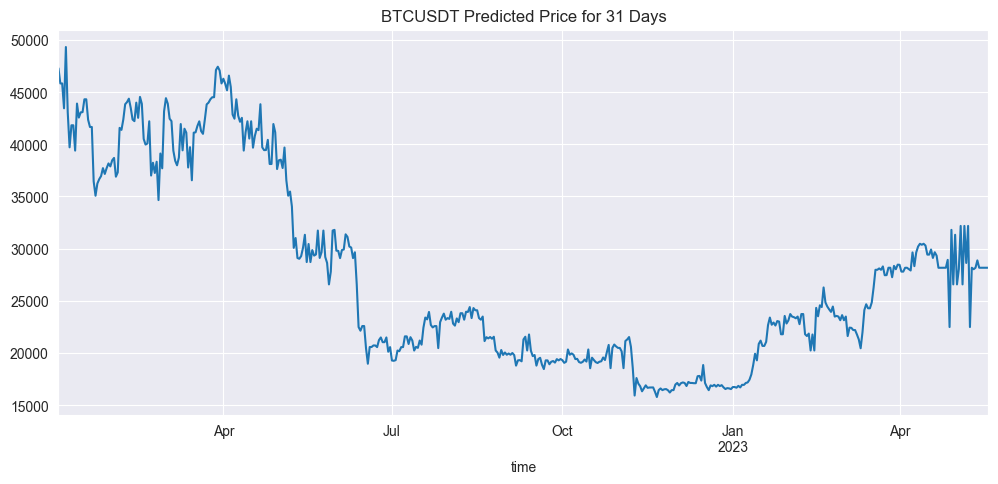

In [122]:
bt_values = future_predictions()
plot_future(bt_values)

In [123]:
def predict_smoothed(regressor, df, scaler, symbol_mapping, prediction_days=30, smooth_average=7):
    # Get the current date
    current_date = datetime.now()

    # Prepare the dataset for prediction
    df_copy = df.copy()
    df_copy['symbol'] = df_copy.symbol.map(symbol_mapping)
    df_scaled = scaler.transform(df_copy.drop(['close'], axis=1))

    # Make the prediction and add it to the dataframe
    df[['t1', 't7', 't30']] = regressor.predict(df_scaled)

    # Smooth the prediction with a rolling mean
    df['plot_me'] = df[f't{prediction_days}'].rolling(smooth_average).mean()

    # Create a new dataframe for the predicted values
    plot = df[-prediction_days:]['plot_me'].values
    predicted_values = pd.DataFrame({'close': plot}, index=pd.date_range(str(df.tail(1).index.values[0]).split("T")[0], periods=prediction_days, freq='D'))

    # Concatenate the original data with the predicted values
    recent_data = df[['close']]
    recent_data.drop(recent_data.tail(1).index, inplace=True)
    final_pred = pd.concat([recent_data, predicted_values], sort=False)

    return final_pred

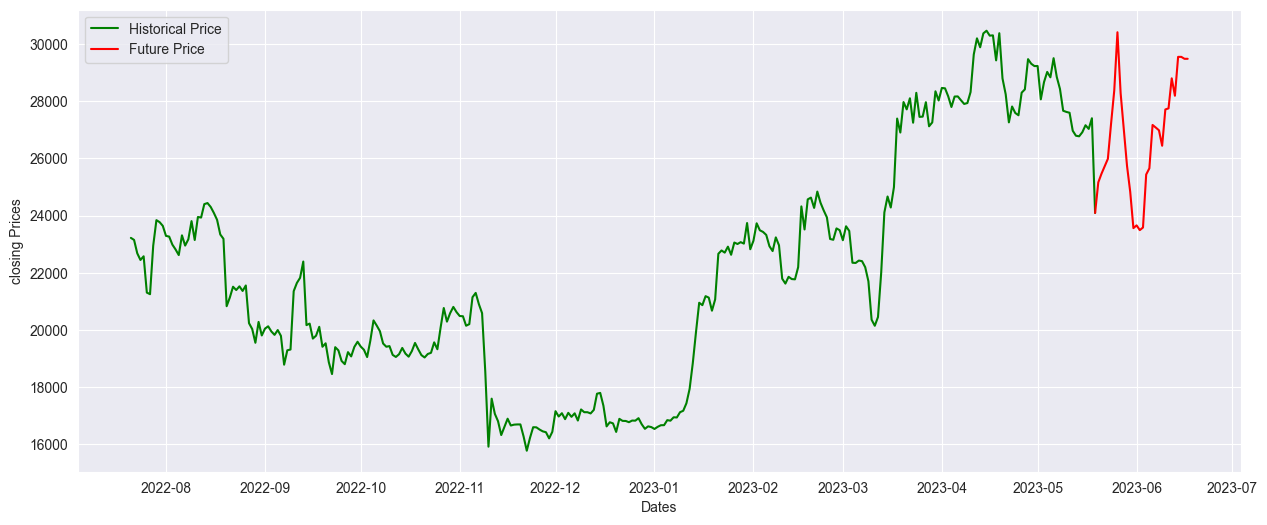

In [124]:
# Define the symbol_mapping dictionary
symbol_mapping = {symbol: i for i, symbol in enumerate(symbols)}

# Get a fresh dataset
df = Dataset().get_data(ticker='BTCUSDT', days=(datetime.now() - datetime(datetime.now().year - 1, 1, 1)).days, ts='1d')
df = pd.DataFrame(df)
df['symbol'] = 'BTCUSDT'
df.reset_index()

# Use the function to make a smoothed prediction
final_pred = predict_smoothed(regressor, df, scaler, symbol_mapping)

# Plot the result
plt.figure(figsize=(15,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('closing Prices')
plt.plot(final_pred[200:-29][['close']], 'green', label='Historical Price')
plt.plot(final_pred[-30:][['close']], 'red', label='Future Price')
plt.legend()
plt.show()